In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [104]:
# 1) Load your data
df = pd.read_csv('../data/mock.tsv', sep='\t')   # or wherever your file lives
df

,Cohort,Label,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
0,Aug,0,1.621774,1.739324,1.451617,-0.186583,2.376608,2.295373,2.722720,1.821542,...,0.864761,0.134935,0.242494,0.359284,0.003831,0.069875,0.259369,0.244837,0.554309,0.733232
1,Aug,0,2.767240,1.079509,-0.723664,1.737466,1.844370,2.059156,2.358058,1.868140,...,0.030889,0.226631,0.329706,0.826815,0.317215,0.114622,0.588142,0.668808,0.491239,0.572640
2,Aug,0,2.122517,0.713271,2.915116,1.313582,2.152386,0.885216,2.853469,0.424814,...,0.830995,0.242558,0.841052,0.958406,0.721642,0.753970,0.840054,0.979133,0.357064,0.194532
3,Aug,0,1.802962,3.129745,2.488166,0.917015,2.729987,1.810858,2.108782,0.664469,...,0.391327,0.153289,0.214403,0.113282,0.563799,0.164133,0.262977,0.387080,0.846162,0.564837
4,Aug,0,0.367035,2.749154,1.558293,1.304794,0.857214,3.152263,1.684176,1.667096,...,0.029424,0.986045,0.232829,0.953272,0.918123,0.857471,0.303726,0.404233,0.050626,0.203764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Mar,1,-1.682147,-1.262470,-3.842003,-2.204974,-0.902512,0.520465,-1.227517,-0.628699,...,0.509399,0.705261,0.230260,0.958283,0.673974,0.601420,0.256721,0.232084,0.994775,0.611156
146,Mar,1,-1.386700,-1.253194,-1.945290,-3.505696,-1.847696,-0.841383,-1.970503,-2.129677,...,0.146937,0.603260,0.806180,0.410741,0.930247,0.837703,0.330396,0.603705,0.338051,0.464377
147,Mar,1,0.296081,-1.919121,0.350761,-1.491252,-1.950832,-2.100143,-1.230885,-0.888188,...,0.991078,0.623959,0.127712,0.553945,0.162934,0.777856,0.835434,0.857982,0.725078,0.798173
148,Mar,1,-1.528270,-2.667680,-1.118364,-2.586643,-1.151861,-1.574978,-3.201278,-2.337745,...,0.080779,0.995426,0.707016,0.680826,0.738497,0.551783,0.526466,0.421607,0.851696,0.403886


In [105]:
df.Cohort.unique()

array(['Aug', 'Jul', 'Mar'], dtype=object)

In [106]:
print(f"Num of sample with Label == 0 is {sum(df.Label==0)}")
print(f"Num of sample with Label == 1 is {sum(df.Label==1)}")

Num of sample with Label == 0 is 100
Num of sample with Label == 1 is 50


In [107]:
# 2) Define feature sets
A_feats    = [c for c in df.columns if c.startswith('A_')]
B_feats    = [c for c in df.columns if c.startswith('B_')]
AB_feats   = A_feats + B_feats
cat_feats  = ['Cohort']       # now included as a model input

In [108]:
# 3) Build X/y (include cohort in X)
X      = df[AB_feats]
y      = df['Label']          # target: 0 or 1
groups = df['Cohort']         # you can still use this for GroupKFold if desired

In [109]:
# 4) Split off a held-out test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [110]:
# 5) Preprocessing pipelines
numeric_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, AB_feats),
])

In [111]:
# 6) Candidate models (with preprocessing built in)
models = {
    'LogisticRegression': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='saga',
            penalty='l2',
            C=1.0,
            max_iter=2000,
            n_jobs=-1,
            random_state=42
        ))
    ]),
}

In [112]:
# --- 1) Re-fit simple models on just A/B features (no cohort) ---
X_AB = df[AB_feats]      # AB_feats = all your A_/B_ columns
y = df['Label']

# Logistic Regression (with scaling)
scaler = StandardScaler().fit(X_AB)
X_scaled = scaler.transform(X_AB)
lr = LogisticRegression(solver='saga', penalty='l2', C=1.0, max_iter=2000, random_state=42)
lr.fit(X_scaled, y)

# --- 2) Extract importances / coefficients ---
lr_coef = pd.Series(lr.coef_.flatten(), index=AB_feats).abs()

# --- 3) Find top feature in each group ---
top_A_lr = lr_coef.filter(like='A_').nlargest(1)
top_B_lr = lr_coef.filter(like='B_').nlargest(1)

print("\n=== Logistic Regression (abs coef) ===")
print("Top A-feature:", top_A_lr.index[0], "coef=", top_A_lr.iloc[0])
print("Top B-feature:", top_B_lr.index[0], "coef=", top_B_lr.iloc[0])


=== Logistic Regression (abs coef) ===
Top A-feature: A_47 coef= 2.4013021779273953
Top B-feature: B_5 coef= 0.6029317758099714


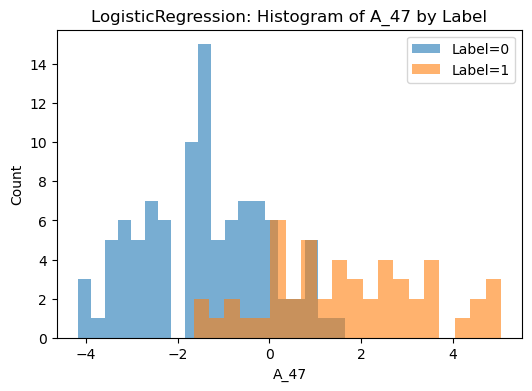

/var/folders/h0/hyrmq_xj0nz_7j032crdtlrh0000gn/T/ipykernel_97570/301399541.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=['0','1'])


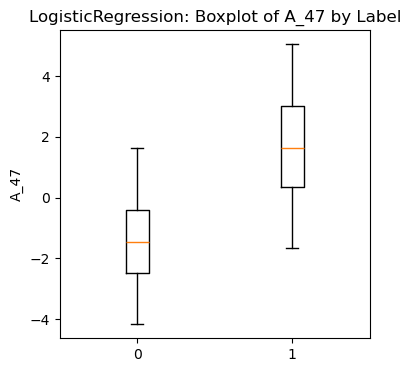

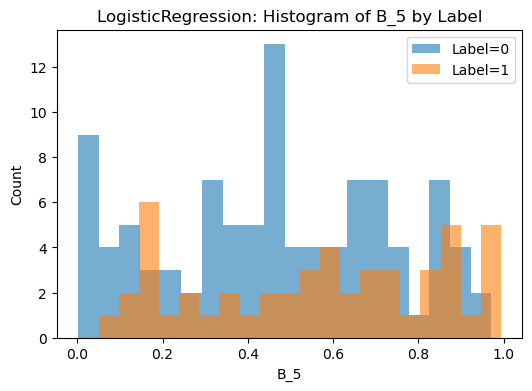

/var/folders/h0/hyrmq_xj0nz_7j032crdtlrh0000gn/T/ipykernel_97570/301399541.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=['0','1'])


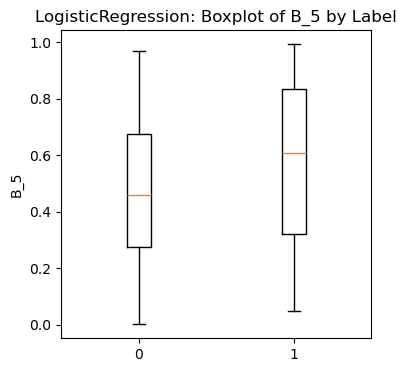

In [114]:
import matplotlib.pyplot as plt

top_feats = {
    'LogisticRegression': {'A': 'A_47', 'B': 'B_5'}
}

for model, feats in top_feats.items():
    for group, feat in feats.items():
        # 1) Overlaid histograms
        plt.figure(figsize=(6,4))
        plt.hist(df.loc[df.Label==0, feat], bins=20, alpha=0.6, label='Label=0')
        plt.hist(df.loc[df.Label==1, feat], bins=20, alpha=0.6, label='Label=1')
        plt.title(f'{model}: Histogram of {feat} by Label')
        plt.xlabel(feat)
        plt.ylabel('Count')
        plt.legend()
        plt.show()

        # 2) Side-by-side boxplot
        data0 = df.loc[df.Label==0, feat]
        data1 = df.loc[df.Label==1, feat]
        fig, ax = plt.subplots(figsize=(4,4))
        ax.boxplot([data0, data1], labels=['0','1'])
        ax.set_title(f'{model}: Boxplot of {feat} by Label')
        ax.set_ylabel(feat)
        plt.show()

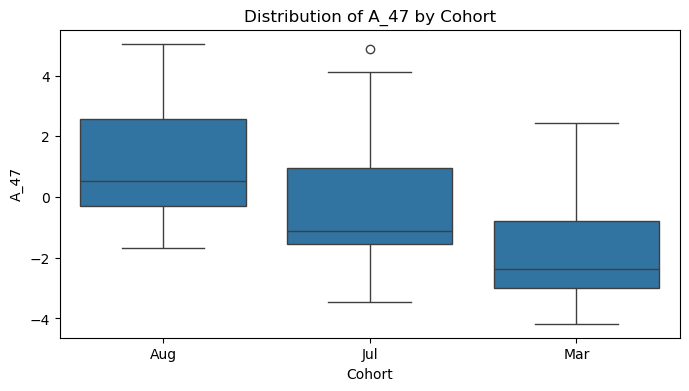

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.boxplot(x='Cohort', y='A_47', data=df, order=sorted(df['Cohort'].unique()))
plt.title('Distribution of A_47 by Cohort')
plt.show()


In [75]:
import pandas as pd

# 1) Suppose df already has your AB_feats list and ‘Cohort’
AB_feats = [c for c in df.columns if c.startswith('A_') or c.startswith('B_')]

# 2) Apply group‐wise scaling: (x - mean_of_cohort) / std_of_cohort
df_scaled = df.copy()
df_scaled[AB_feats] = (
    df_scaled
      .groupby('Cohort')[AB_feats]
      .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
)

# 3) Now df_scaled[AB_feats] contains cohort-normalized values.
#    You can drop ‘Cohort’ (or still encode it) and train on df_scaled:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # optional: further global scaling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

X = df_scaled[AB_feats]     # cohort effects removed
y = df_scaled['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline([
    # Optional: a second, global scaler if you like:
    ('global_scale', StandardScaler()),
    ('clf', LogisticRegression(solver='saga', max_iter=2000, random_state=42))
])
pipe.fit(X_train, y_train)

y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC-ROC:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.67      0.60      0.63        10

    accuracy                           0.77        30
   macro avg       0.74      0.72      0.73        30
weighted avg       0.76      0.77      0.76        30

Test AUC-ROC: 0.8800000000000001


In [76]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# 1) Work on your cohort-scaled DataFrame:
#    df_scaled[AB_feats] already has (x - μ_cohort)/σ_cohort
X = df_scaled[AB_feats]
y = df_scaled['Label']

# 2) Compute AUC for each feature individually
feature_aucs = {}
for feat in AB_feats:
    # roc_auc_score will treat feat as a “score” for Label=1
    feature_aucs[feat] = roc_auc_score(y, X[feat])

# 3) Split into A_ and B_ lists and pick the top
A_auc = {f: feature_aucs[f] for f in A_feats}
B_auc = {f: feature_aucs[f] for f in B_feats}

top_A = max(A_auc, key=A_auc.get)
top_B = max(B_auc, key=B_auc.get)

print(f"Top A feature: {top_A} → AUC = {A_auc[top_A]:.3f}")
print(f"Top B feature: {top_B} → AUC = {B_auc[top_B]:.3f}")


Top A feature: A_47 → AUC = 0.985
Top B feature: B_41 → AUC = 0.614


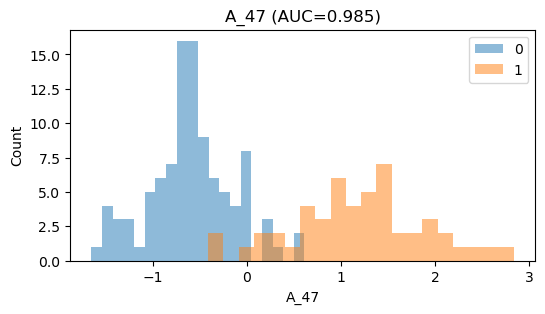

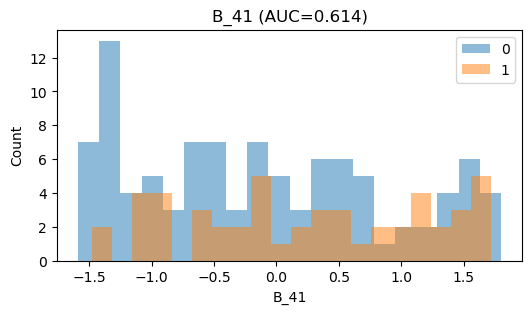

In [77]:
import matplotlib.pyplot as plt

for feat, auc in [('A_47', 0.985), ('B_41', 0.614)]:
    plt.figure(figsize=(6,3))
    plt.hist(df_scaled.loc[df_scaled.Label==0, feat], bins=20, alpha=0.5, label='0')
    plt.hist(df_scaled.loc[df_scaled.Label==1, feat], bins=20, alpha=0.5, label='1')
    plt.title(f'{feat} (AUC={auc:.3f})')
    plt.xlabel(feat); plt.ylabel('Count'); plt.legend()
    plt.show()


In [80]:
# Assume df_scaled already has (x - mean_cohort)/std_cohort for A_47
X = df_scaled[['A_47']]
y = df_scaled['Label']

# 1) Hold out a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) Fit Logistic Regression
clf = LogisticRegression(
    solver='liblinear',   # fine for 1D
    random_state=42
).fit(X_train, y_train)

# 3) Predict & Evaluate
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC-ROC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Test AUC-ROC: 0.98


In [81]:
# Assume df_scaled already has (x - mean_cohort)/std_cohort for A_47
X = df_scaled[['A_47']]
y = df_scaled['Label']

# 1) Hold out a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) Fit Logistic Regression
clf = LogisticRegression(
    solver='liblinear',   # fine for 1D
    random_state=42
).fit(X_train, y_train)

# 3) Predict & Evaluate
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC-ROC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Test AUC-ROC: 0.98


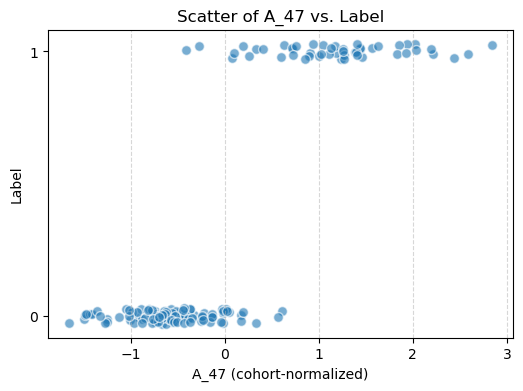

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Extract x and y
x = df_scaled['A_47']
y = df_scaled['Label']

# 2) Add a bit of jitter on y so 0’s and 1’s don’t fully overlap
y_jitter = y + np.random.uniform(-0.03, 0.03, size=len(y))

# 3) Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(x, y_jitter, alpha=0.6, edgecolor='w', s=50)
plt.yticks([0,1])
plt.xlabel('A_47 (cohort-normalized)')
plt.ylabel('Label')
plt.title('Scatter of A_47 vs. Label')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()
